# Figure 5 inspection
In optimal reaching for the sum of (work,forcerate,time), we need to convert to a single unit of annoyance, namely Joules.

here we do a small sensitivity-analysis along two parameters:

- the valuation of time
- the valuation of the force-rate cost


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2428
Number of nonzeros in inequality constraint Jacobian.:     1072
Number of nonzeros in Lagrangian Hessian.............:      817

Total number of variables............................:      919
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      528
Total number of inequality constraints...............:      665
        inequality constraints with only lower bounds:      256
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      409

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

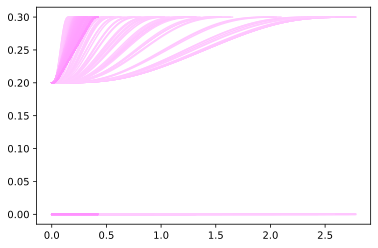

In [16]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import ReachingModels as reaching
import numpy as np
import matplotlib.pyplot as plt
import colour as clr
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(0,'parameterFiles')

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = reaching.PointMass()

# starting x and y
x = 0.0
ys = 0.20
xystart = np.array([x,ys])

loopValuation = [50, 1, .25]
loopdist = np.array([.1])

color1 = clr.Color("#e0f3db")
distcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))

### storing the main results: durations, speeds, costs.
M = len(loopValuation)
N = len(loopdist)
duration      = np.zeros([M, N])
J             = np.zeros([M, N])
costFR        = np.zeros([M, N])
costWork      = np.zeros([M, N])
costTime      = np.zeros([M, N])
peakhandspeed = np.zeros([M, N])
solved        = np.zeros([M, N])
distances     = np.zeros([M, N])
nDist         = 0 #counters
mVal          = 0 #counters

### store returned trajectories
# store trajectories
trajAll       = list() #ultimately the 2D matrix storage
trajFixedDist = list() # fixedDist get reset each inner loop
# store returned Opti variables
optiAll       = list() # ultimately the 2D matrix storage 
optiFixedDist = list() # fixedDist get reset each inner loop

### setup the optimization. 
optiPrev = sim.movementTimeOptSetup(
  theN              = 50,
  theTimeValuation  = 1.0)

frValuations = [8.5e-5,8.5e-2,8.5e-1]
### solve the nominal optimization 
trajOrig, optiOrig = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]), 
  theDurationGuess    = 0.5,
  theTimeValuation    = 1,        # seems to be roughly how much people care about time?..
  theGeneratePlots    = 0,
  theFRCoef=frValuations[1])               # from Wong Cluff Kuo 2021.
dGuess = trajOrig.duration

# make the muscle-activation (i.e. force-rate) cost very high! J = forceRate + time
trajHighFR, optiHighFR = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]), 
  theDurationGuess    = 0.5,
  theTimeValuation    = 1,
  theGeneratePlots    = 0,
  theFRCoef=frValuations[2])

# make the muscle activation cost very low. J = work + time
trajLowFR, optiLowFR = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]), 
  theDurationGuess    = 0.5,
  theTimeValuation    = 1,
  theGeneratePlots    = 0,
  theFRCoef=frValuations[0])

frSims    = [trajLowFR,  trajOrig, trajHighFR]
frLabels  = ["low FR", "nominal", "high FR"]
frValuations = frValuations #reminder of the order!
timeValuations = [1,1,1]

# Inspection
Show the bell-shaped trajectories and the three terms in the objective:
- mechanical work
- force rate
- time


In [17]:


# plot the three simulations over each other, showing the cost components.
def inspection(listTraj,labels,frcosts):
  color1 = clr.Color("#e0f3db")
  colors = list(color1.range_to(clr.Color("#084081"),len(listTraj)))
  ic = 0
  cmPerIn = 2.54
  widthCM = 25 #cm
  heightCM = 30 #cm
  fig, axs = plt.subplots(4, 2, sharex=False, figsize = (widthCM/cmPerIn,heightCM/cmPerIn))
  for itraj,ifrcost,ilabel in zip(listTraj,frcosts,labels):
    axs[0, 0].plot(itraj.time, itraj.handspeed, color = colors[ic].get_hex(),label = ilabel)
    axs[0, 0].set_ylabel("Speed [m/s]")
    
    axs[1, 0].plot(itraj.time, itraj.mechPower.T,color = colors[ic].get_hex(),label = ilabel)
    axs[1, 0].set_ylabel("Mechanial power [W]")
    axs[2, 0].plot(itraj.time, itraj.uraterate.T * ifrcost,color = colors[ic].get_hex(),label = ilabel)
    axs[2, 0].set_ylabel("Torque rate per time [W]")
    axs[2, 0].set_ylim([-5,5])
    nT = np.shape(itraj.time)[0]
    axs[3, 0].plot(itraj.time, np.ones(nT)*itraj.costTime/itraj.time[-1],color = colors[ic].get_hex(),label = ilabel)
    axs[3, 0].set_ylabel("Time cost [W]")

    axs[1, 1].bar(ic, itraj.costWork, color = colors[ic].get_hex())
    axs[1, 1].set_ylabel("Cost [J]")
    axs[1,1].xaxis.set_ticks([0,1,2])
    axs[1,1].set_xticklabels(labels)
    axs[2, 1].bar(ic, itraj.costFR, color = colors[ic].get_hex())
    axs[2, 1].set_ylabel("Cost [J]")
    axs[2,1].xaxis.set_ticks([0,1,2])
    axs[2,1].set_xticklabels(labels)
    axs[3, 1].bar(ic, itraj.costTime, color = colors[ic].get_hex())
    axs[3, 1].set_ylabel("Cost [J]")
    axs[3,1].xaxis.set_ticks([0,1,2])
    axs[3,1].set_xticklabels(labels)
    
    ic+=1
  axs[0,0].legend(loc='upper right')
  plt.show()




## Force-rate coefficient
Note that it affects the speed profile (high force-rate-> very bell-shaped), and also increases movement duration. 

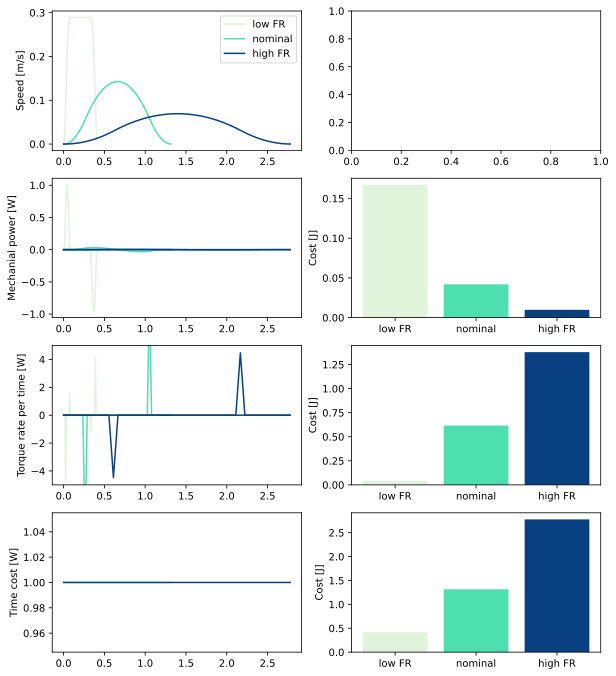

In [18]:

inspection(frSims, frLabels,frValuations)

# Changing the time cost shifts the solution around, but leaves the trajectory essentially the same.

In [ ]:
# make the timevaluation very high! J = forceRate + Time
timevals = []
trajHighTime, optiHighTime = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([x,.1]), 
      theDurationGuess  = dGuess,
      theTimeValuation    = 200,  # in Watts
      theFRCoef=8.5e-2,
      theGeneratePlots    = 0)

# make the timevaluation very low! J = work + forceRate
trajLowTime, optiLowTime = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([x,.1]), 
      theDurationGuess    = dGuess,
      theTimeValuation    = .1,   # in Watts
      theFRCoef=8.5e-2,
      theGeneratePlots    = 0)



timeSims = [trajLowTime,  trajOrig, trajHighTime]
timeLabels = ["low Time", "nominal", "high Time"]
frValuations = [8.5e-2,8.5e-2,8.5e-2]
timeValuations = [.1,1,200]
inspection(timeSims, timeLabels,frValuations,timeValuations)